Time tracking: 2h

In [1]:
import pandas as pd
import joblib
import shap
from shap.maskers import Independent
import matplotlib.pyplot as plt
from comparers import ModelComparer, plot_decision_boundary, _encode_one_hot, _calc_log_odds_from_log_proba
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       merge_explanations, ensure_shap_values_are_3d
import numpy as np
import pandas as pd
import pickle
import cloudpickle
from matplotlib.colors import Normalize
import scipy as sp
from util import get_rules
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.cm as cm
shap.initjs()
%matplotlib inline
task_name = '03'

In [2]:
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)
with open(task_name + '.expl', 'rb') as f:
    explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
feature_order, _ = calc_feature_order(explanations.mclass_diff.log_odds)

In [3]:
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor

In [4]:
X = pd.read_csv('test_data.csv')
y = X['price']
X = X.drop(columns=['Unnamed: 0', 'price'])
feature_names = X.columns.to_numpy()
class_names = y.unique().astype(str)
X = X.to_numpy()
y = y.to_numpy()

In [5]:
y = y.astype(str)
d = dict([(feature_name, feature_data)
          for feature_name, feature_data
          in zip(feature_names, [x for x in X.T])])
d |= {'y': y}
df = pd.DataFrame(d)
dataset = prepare_df(df, 'test', 'y')

# Local Explanations

In [6]:
shap_values = explanations.mclass_diff.log_odds[:, :, :]
shap_values = ensure_shap_values_are_3d(shap_values)
values = shap_values.values.reshape(
        (shap_values.values.shape[0],
         shap_values.values.shape[1] * shap_values.values.shape[2]))
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

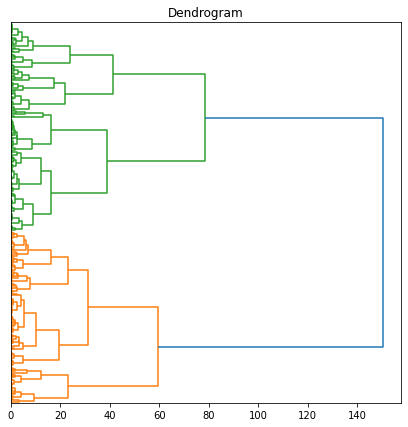

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

In [26]:
n_clusters = 15
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust')
clustering -= 1

In [27]:
explanations_clustered = explanations.cohorts(cluster_names[clustering])

In [28]:
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)"
c1,0,0,0,0,10,0,0,1,0
c2,0,0,0,0,0,0,0,1,11
c6,0,0,0,0,1,3,0,0,5
c13,0,0,0,0,5,2,0,0,1
c14,2,2,0,0,6,0,0,0,0
c15,6,1,0,2,11,0,0,0,0


Like in the comparison of A vs. B, clusters are spread across the range of LSTAT.

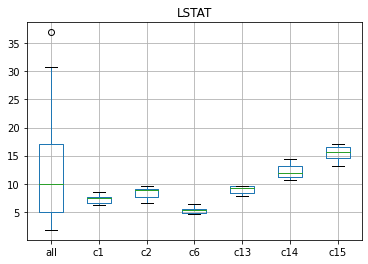

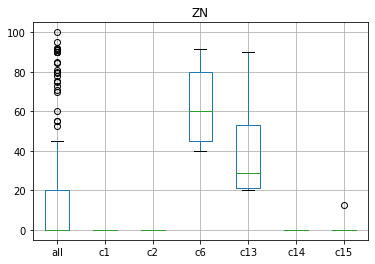

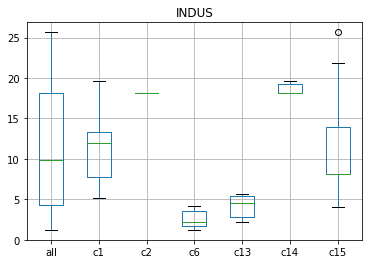

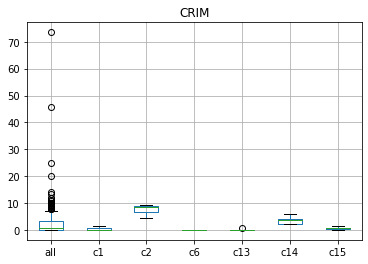

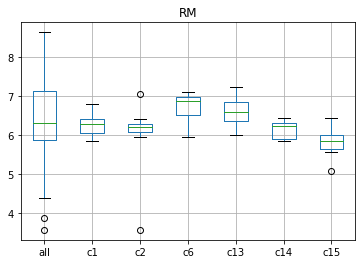

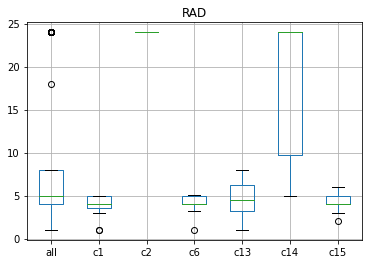

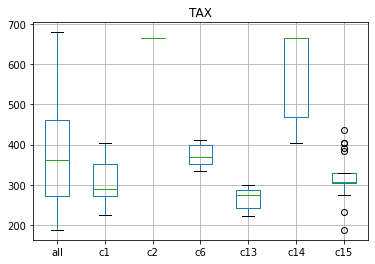

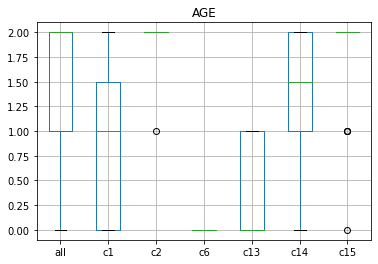

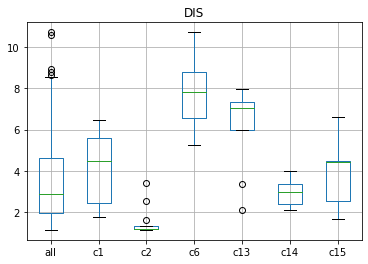

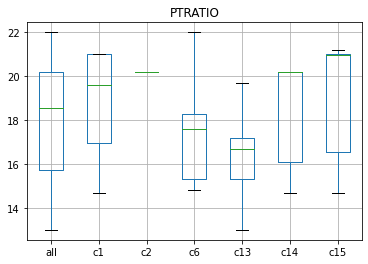

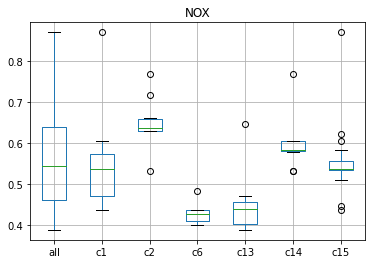

In [29]:
for feature_name in comparer.feature_names[feature_order]:
    df = pd.concat([pd.Series(explanations[:, feature_name].data)] +
                   [pd.Series(explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, feature_name].data)
                    for cluster in clusters_of_interest], axis=1)
    df.columns = ['all'] + clusters_of_interest.tolist()
    df.boxplot()
    plt.title(feature_name)
    plt.show()

In [30]:
feature_idx_of = lambda feature_name: np.where(comparer.feature_names == feature_name)[0][0]
class_idx_of = lambda class_name: np.where(comparer.class_names == class_name)[0][0]

In [31]:
def plot_decision(shap_values, highlight=None):
    plt.title(shap_values.output_names)
    shap.decision_plot(shap_values.base_values[0], shap_values.values, shap_values.feature_names,
                       highlight=highlight)

In [32]:
def plot_diro2c(X_diff, y_diff, feature_x, feature_y, xlim=None, ylim=None):
    idx_x, idx_y = feature_idx_of(feature_x), feature_idx_of(feature_y)
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    for class_idx, class_label in [(0, 'no_diff'), (1, 'diff')]:
        mask = y_diff == class_idx
        ax.scatter(X_diff[mask, idx_x], X_diff[mask, idx_y], label=class_label, alpha=0.5)
    ax.legend()

## 1st cluster (mean LSTAT = 7.2)

In [111]:
cluster = clusters_of_interest[0]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

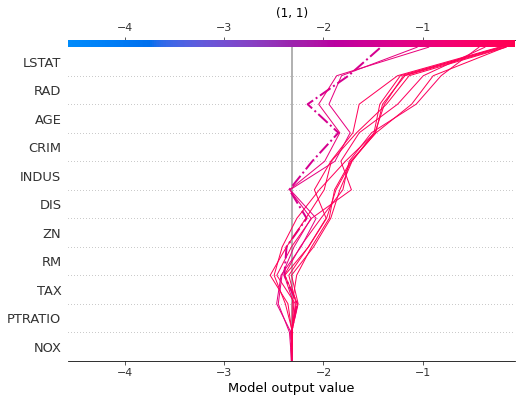

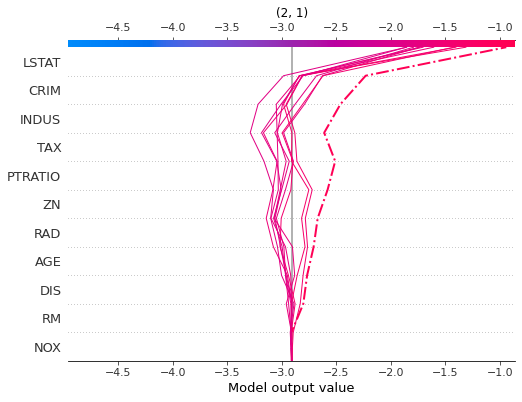

In [34]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

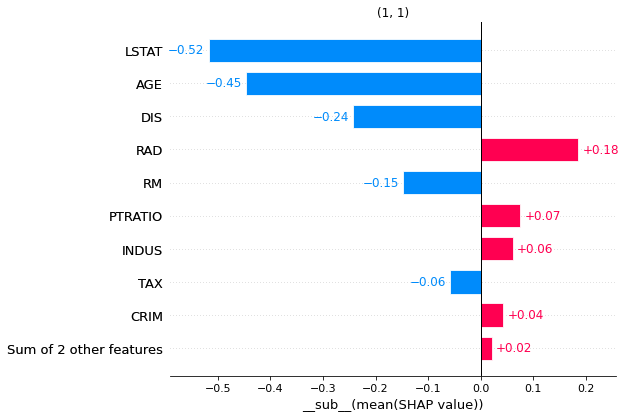

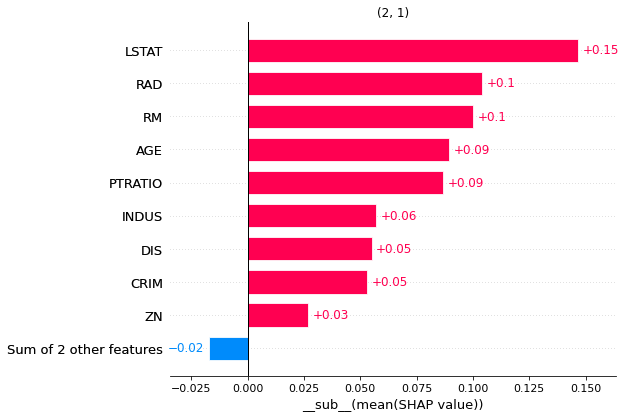

In [35]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [36]:
top_features = ['LSTAT', 'AGE', 'DIS']

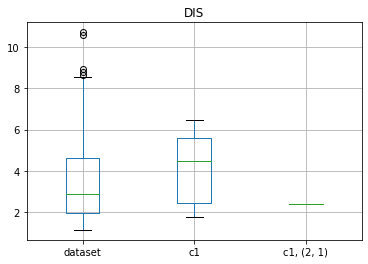

dataset       3.501706
c1            4.130027
c1, (2, 1)    2.388900
dtype: float64


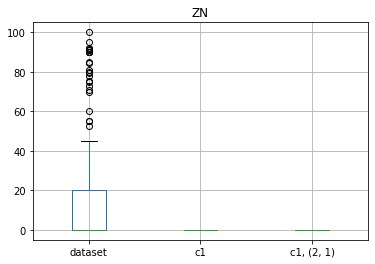

dataset       12.841063
c1             0.000000
c1, (2, 1)     0.000000
dtype: float64


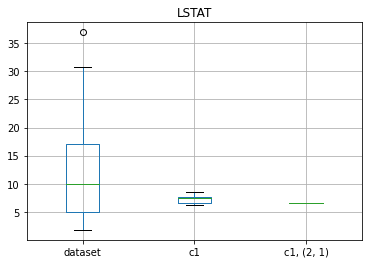

dataset       11.736981
c1             7.220000
c1, (2, 1)     6.480000
dtype: float64


In [112]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()
    print(df.mean())

### Feature effects

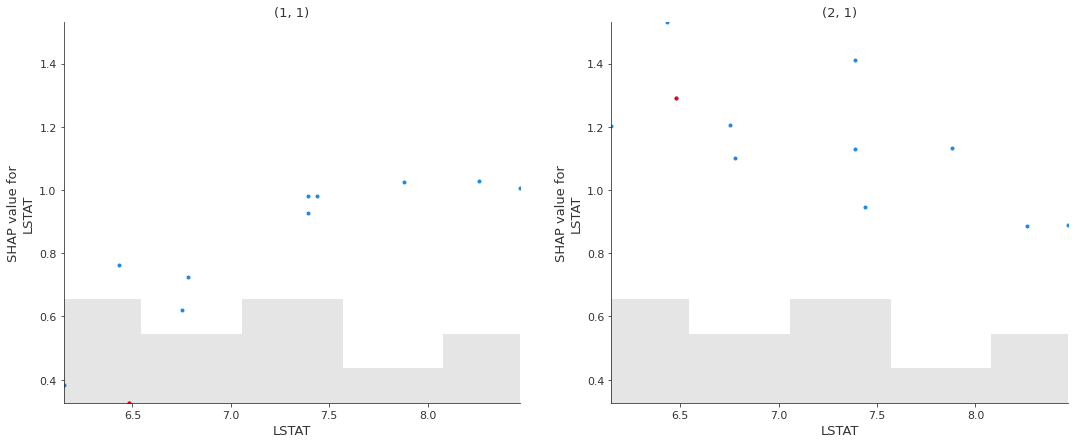

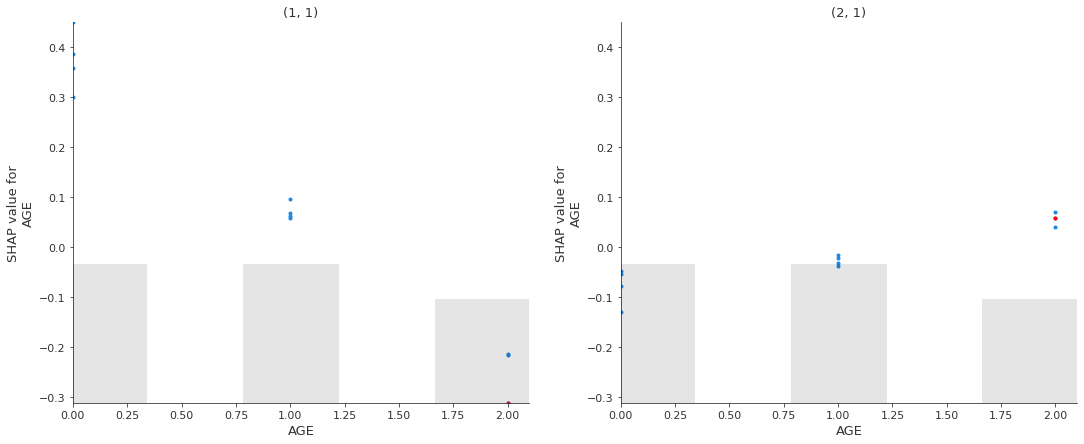

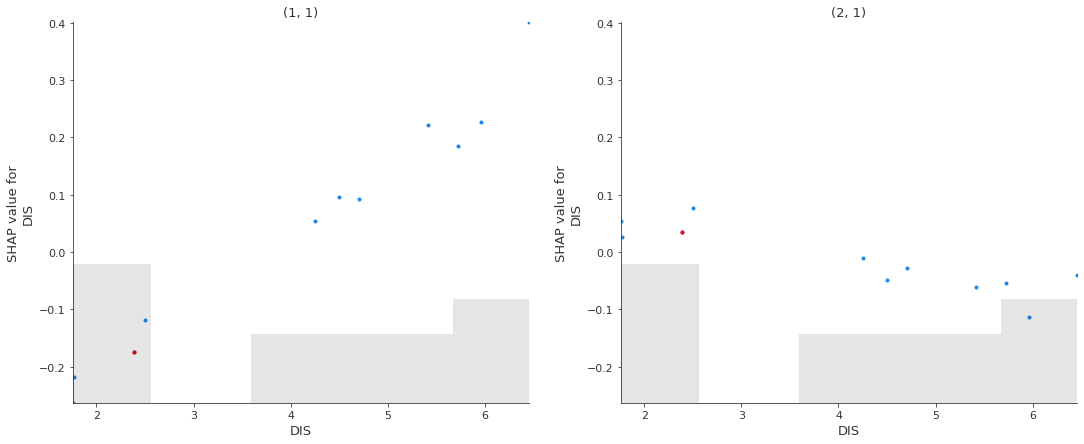

In [38]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the feature's value, I found out that the classifiers don't agree always for these instances:
- AGE: 2
- DIS: up to 4.2

In [40]:
idx_feature = feature_idx_of('AGE')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] = 1
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [2.]
['(1, 1)']
stop:  [1.]


In [41]:
idx_feature = feature_idx_of('DIS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
while not np.all(pred_class_names == '(1, 1)'):
    d[:, idx_feature] += 0.1
    pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(f'stop:  {d[:, idx_feature]}')

start: [2.3889]
stop:  [4.1889]


### diro2c

In [43]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 47.7 s, sys: 626 ms, total: 48.3 s
Wall time: 54.1 s


diro2c suggests, that there are a lot more differences all over the range of AGE and DIS for the concerned ranges of LSTAT.

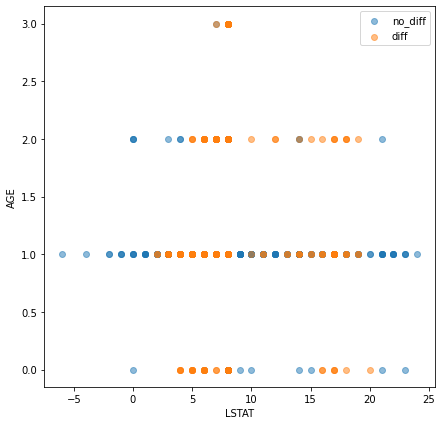

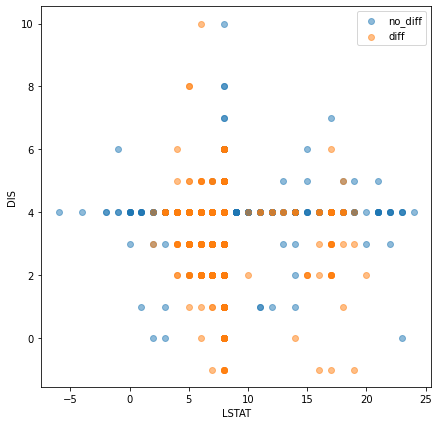

In [44]:
for feature in top_features:
    if feature != 'LSTAT':
        plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', feature)

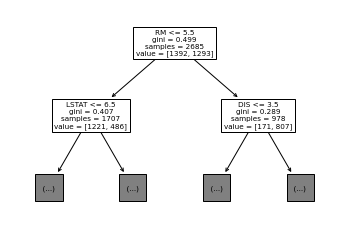

In [45]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 2nd cluster (mean LSTAT = 8.37)

In [46]:
cluster = clusters_of_interest[1]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

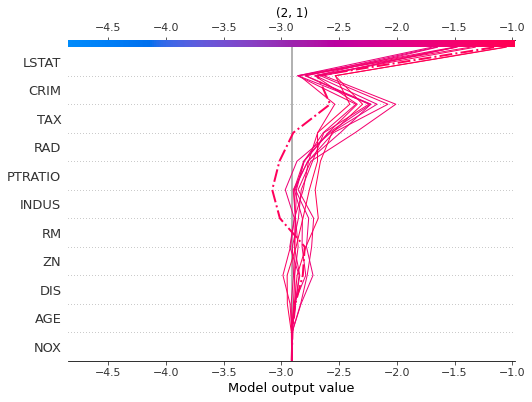

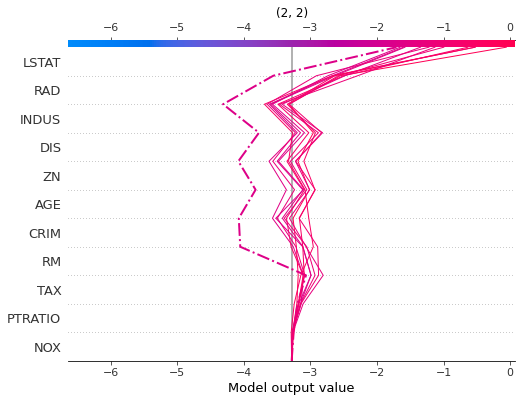

In [47]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

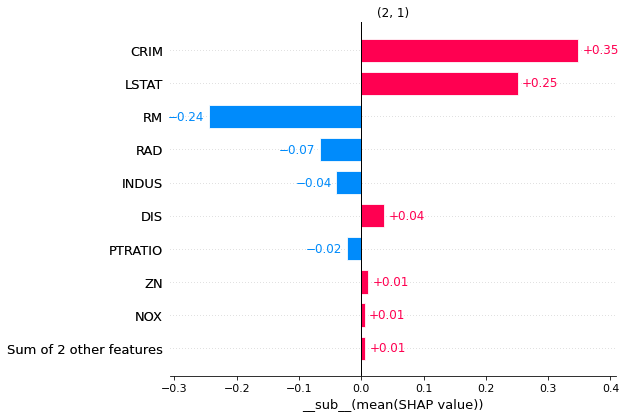

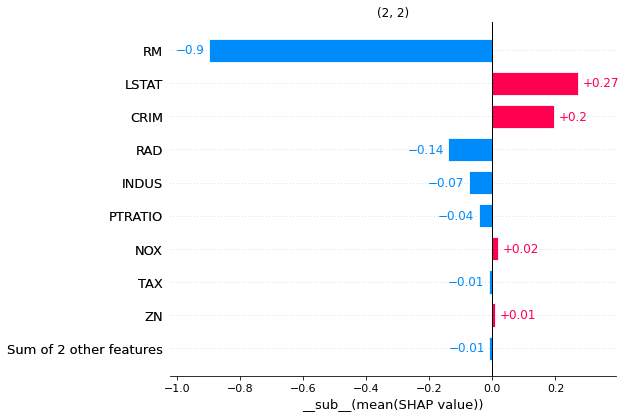

In [48]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [49]:
top_features = ['CRIM', 'LSTAT', 'RM']

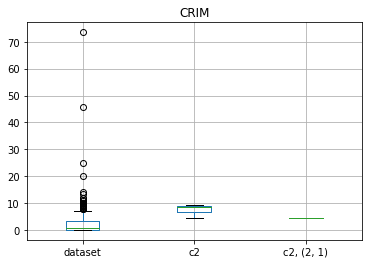

dataset       2.720010
c2            7.684149
c2, (2, 1)    4.555870
dtype: float64


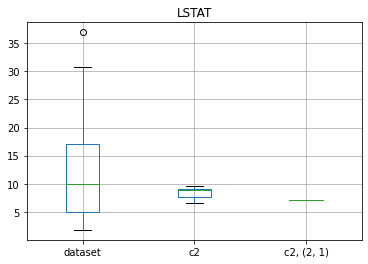

dataset       11.736981
c2             8.373300
c2, (2, 1)     7.120000
dtype: float64


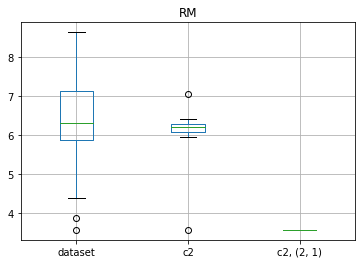

dataset       6.511388
c2            6.036292
c2, (2, 1)    3.561000
dtype: float64


In [104]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()
    print(df.mean())

### Feature effects

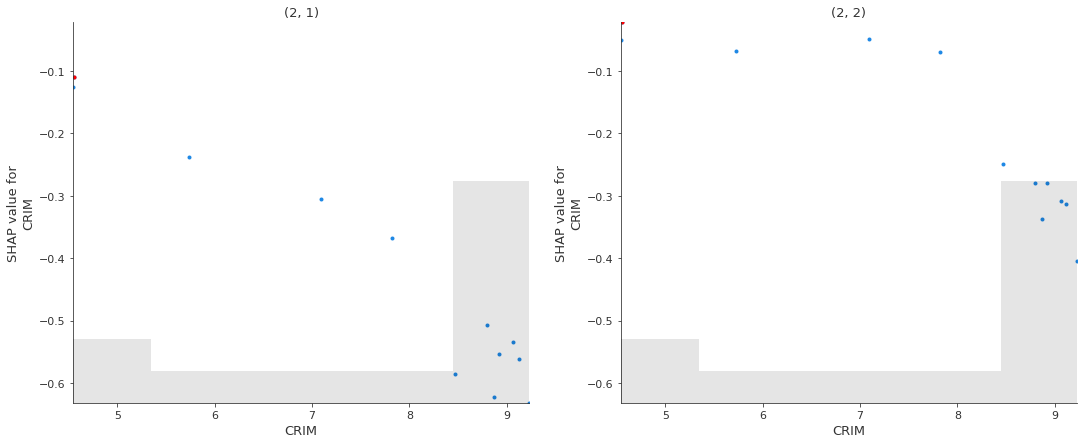

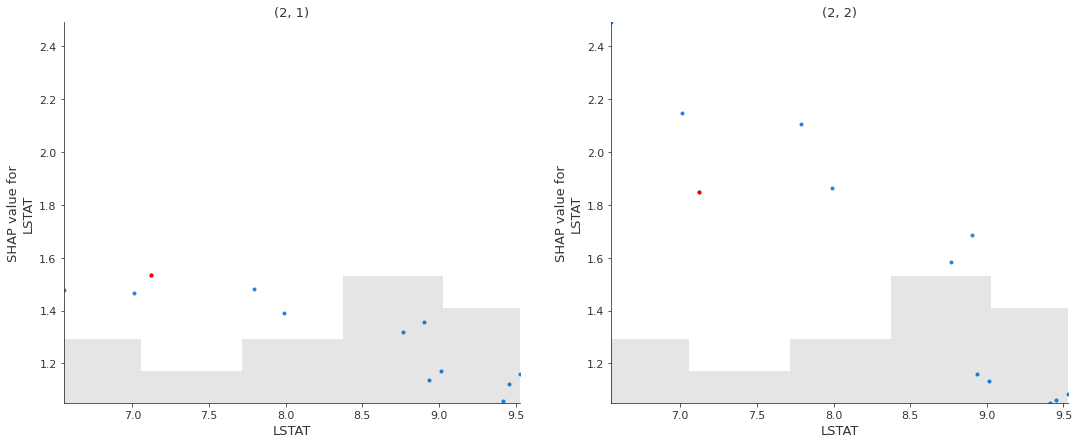

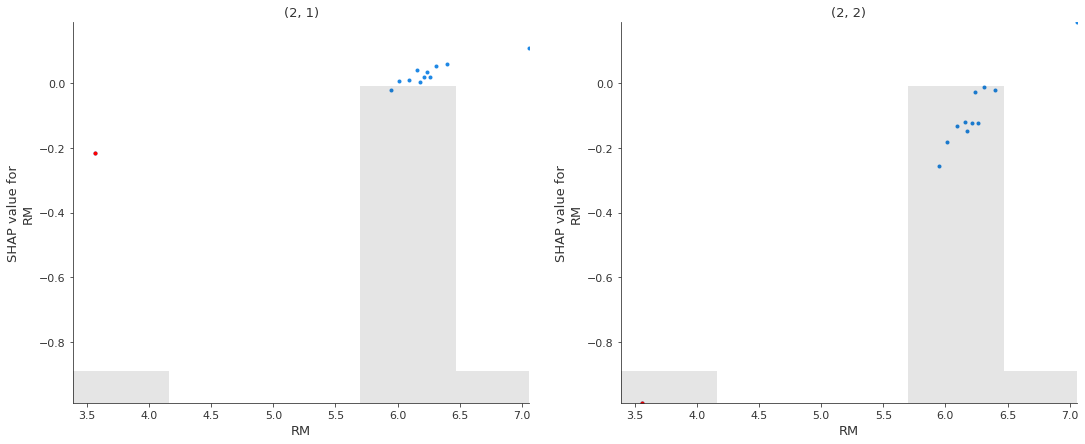

In [51]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the feature's value, I found out that the classifiers don't agree always for these instances:
- CRIM: increasing it alone does not work
- RM: 3.3 - 4.6

In [93]:
idx_feature = feature_idx_of('RM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] += 1
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [3.561]
['(2, 2)']
stop:  [4.561]


In [100]:
idx_feature = feature_idx_of('RM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] -= 0.3
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [3.561]
['(1, 1)']
stop:  [3.261]


### diro2c

In [101]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 52.4 s, sys: 584 ms, total: 53 s
Wall time: 1min 2s


For CRIM, we see less difference from 10 upwards. This is already outside the cluster values, which I didn't try before. For RM, there are no differences at 3, confirming the previous finding but suggesting possible other differences for higher values above 5.

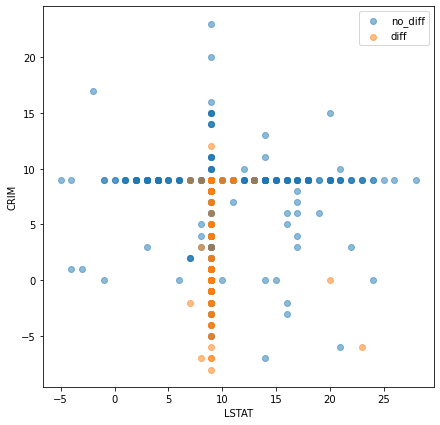

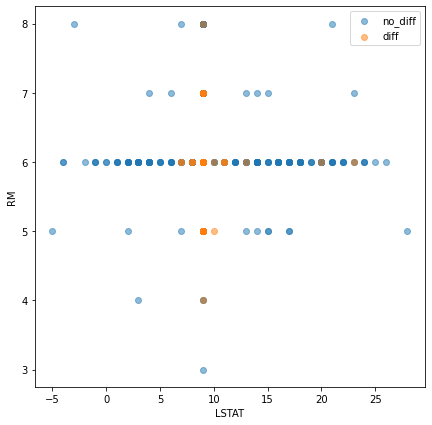

In [102]:
for feature in top_features:
    if feature != 'LSTAT':
        plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', feature)

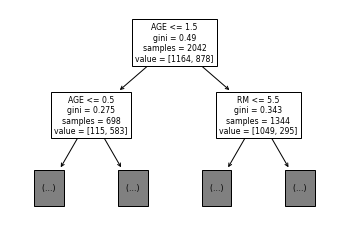

In [105]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 3rd cluster (mean LSTAT = 5.3)

In [115]:
cluster = clusters_of_interest[2]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

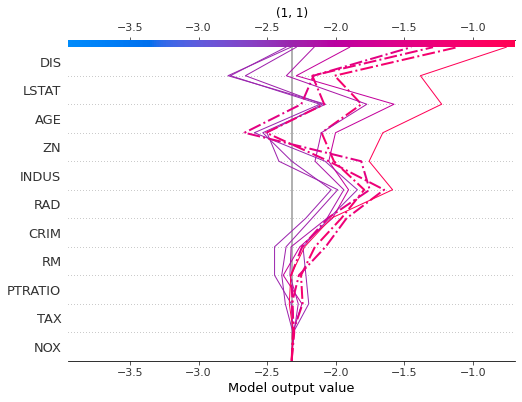

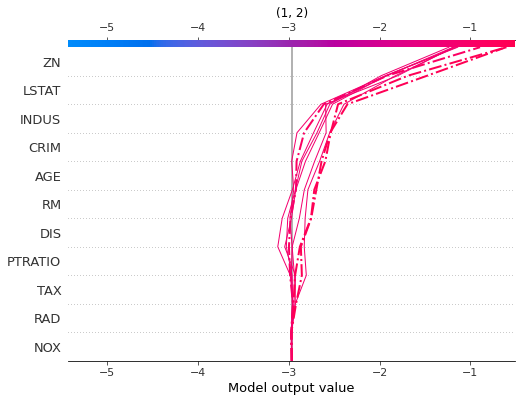

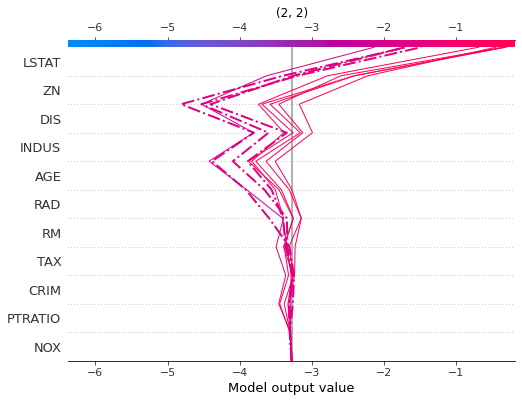

In [116]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

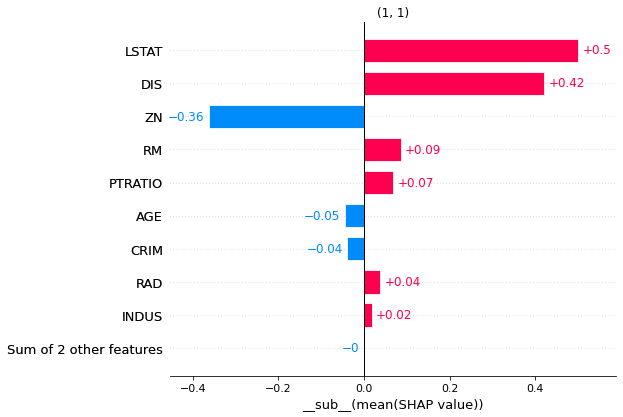

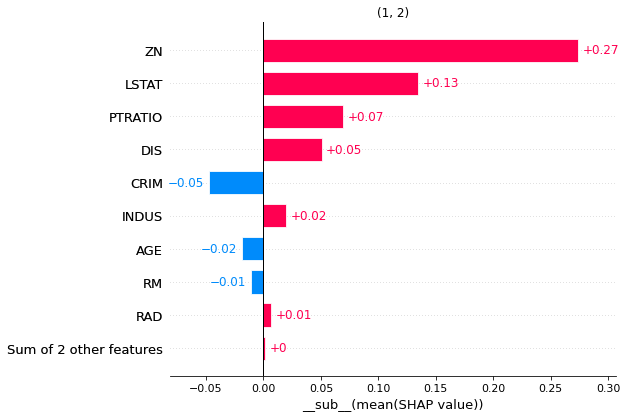

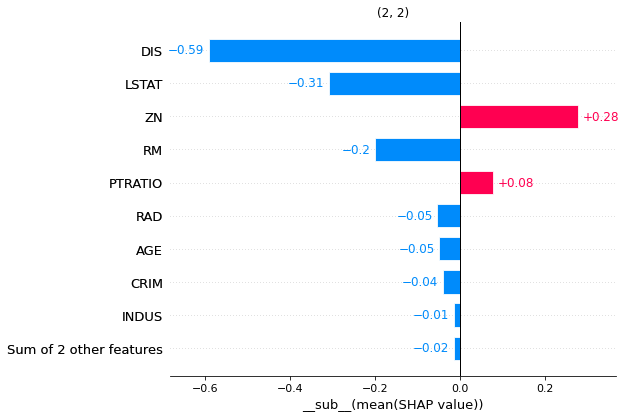

In [117]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [118]:
top_features = ['DIS', 'ZN', 'LSTAT']

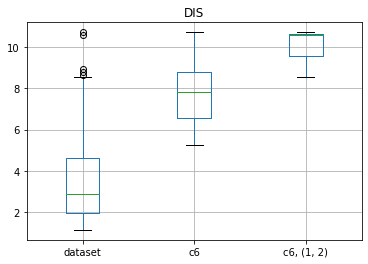

dataset       3.501706
c6            8.032206
c6, (1, 2)    9.943767
dtype: float64


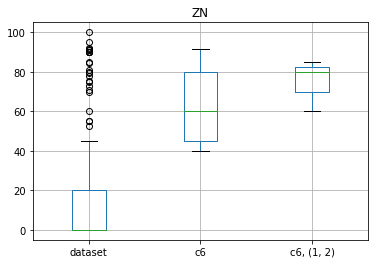

dataset       12.841063
c6            63.417797
c6, (1, 2)    75.000000
dtype: float64


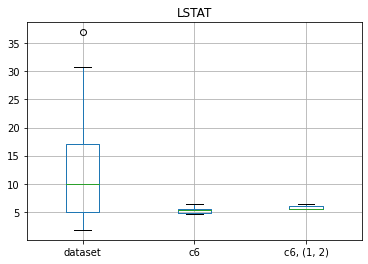

dataset       11.736981
c6             5.299141
c6, (1, 2)     5.806667
dtype: float64


In [119]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()
    print(df.mean())

### Feature effects

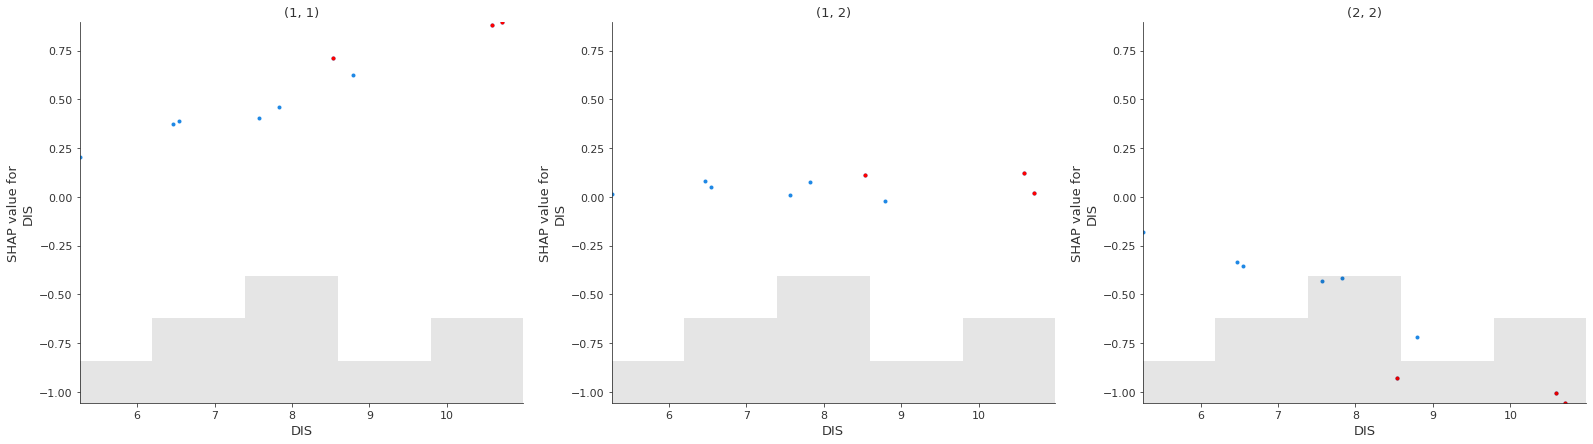

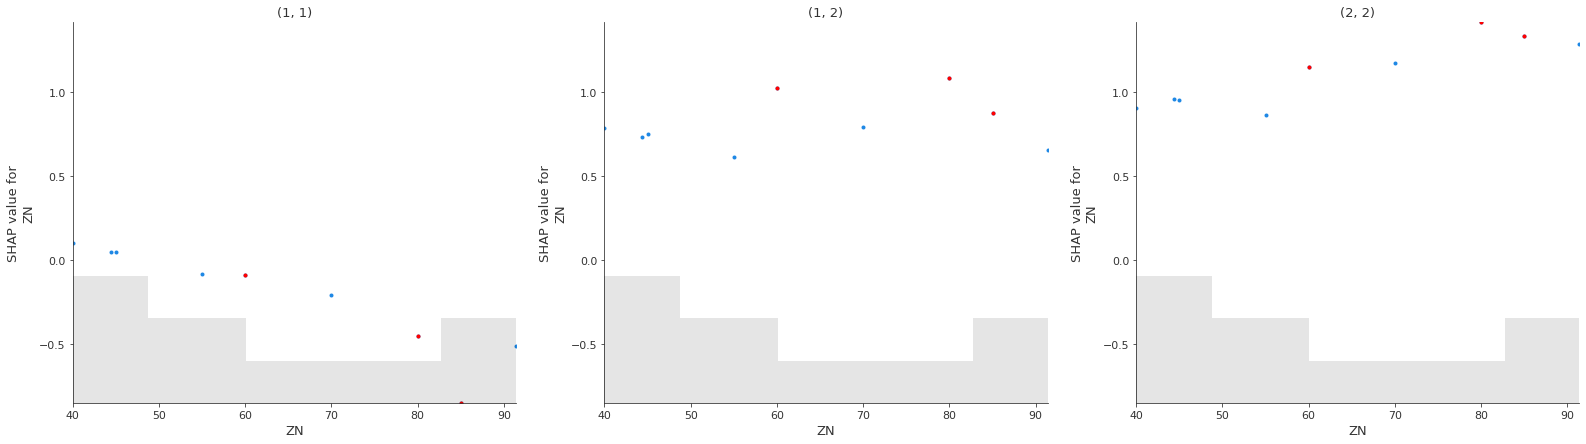

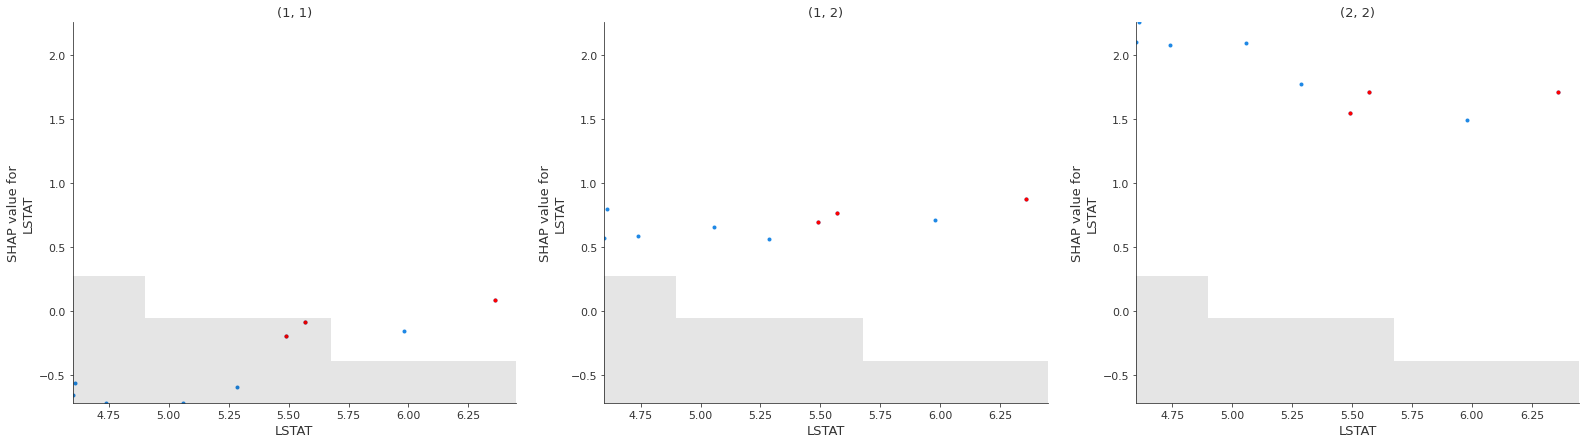

In [120]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the feature's value, I found out that the classifiers don't agree always for these instances:
- DIS: >4.2
- ZN: >29

In [139]:
idx_feature = feature_idx_of('DIS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] -= 4.3
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [10.7103  8.5353 10.5857]
['(2, 2)' '(2, 2)' '(2, 2)']
stop:  [6.4103 4.2353 6.2857]


In [152]:
idx_feature = feature_idx_of('ZN')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] -= 31
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [60. 85. 80.]
['(1, 1)' '(1, 1)' '(1, 1)']
stop:  [29. 54. 49.]


### diro2c

In [159]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 41.8 s, sys: 480 ms, total: 42.2 s
Wall time: 42.9 s


For DIS, there are difference everywhere for the LSTAT value of interest, except a bit less for DIS=0. For ZN, there are less differences around 25, but then again more below.

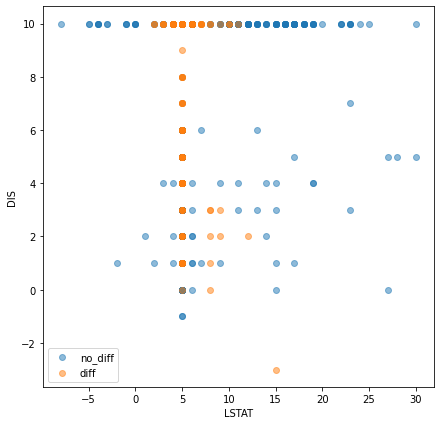

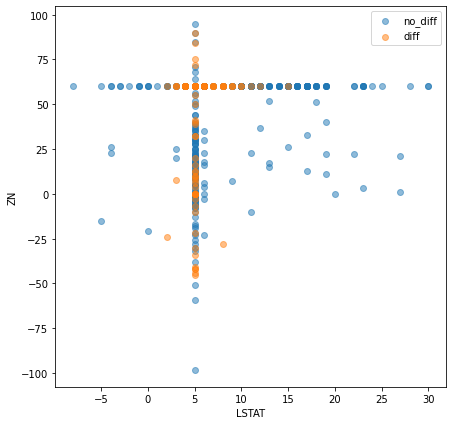

In [160]:
for feature in top_features:
    if feature != 'LSTAT':
        plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', feature)

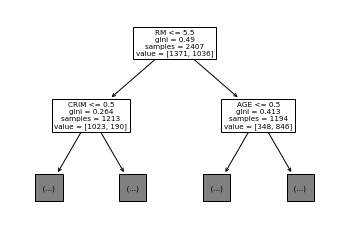

In [161]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 4th cluster (mean LSTAT = 8.9)

In [163]:
cluster = clusters_of_interest[3]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

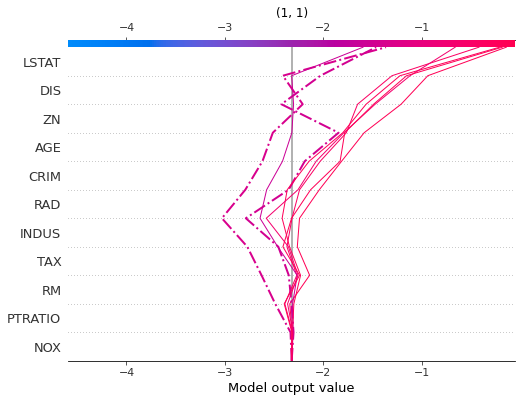

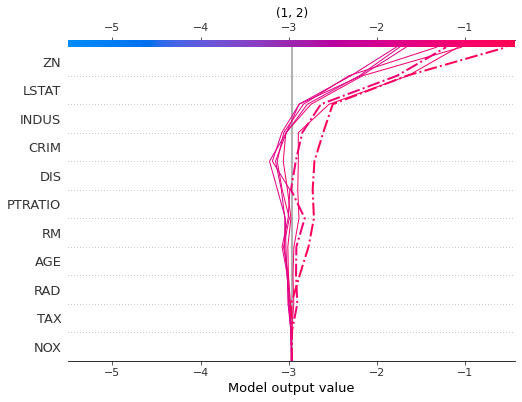

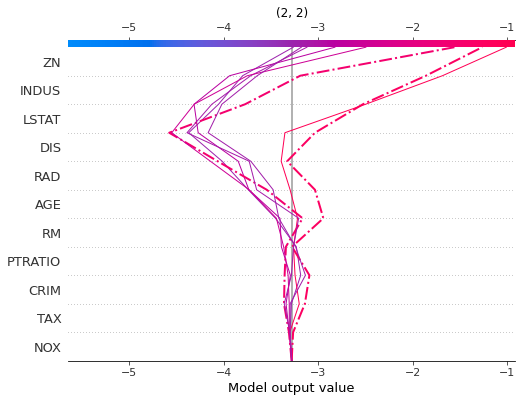

In [164]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

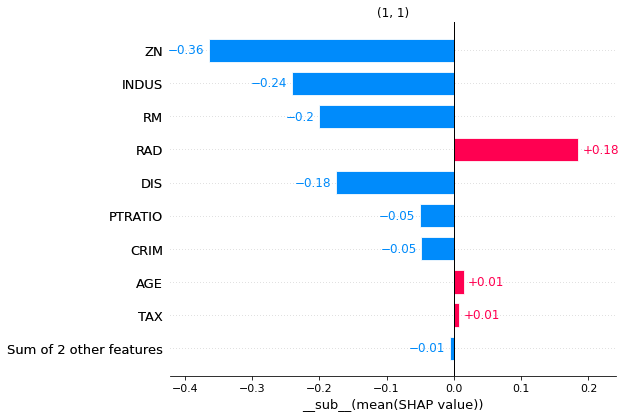

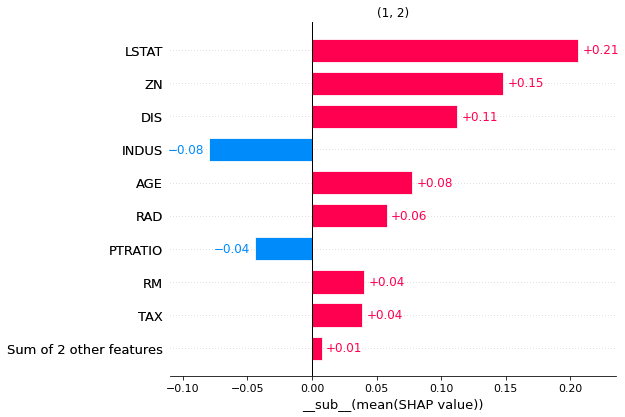

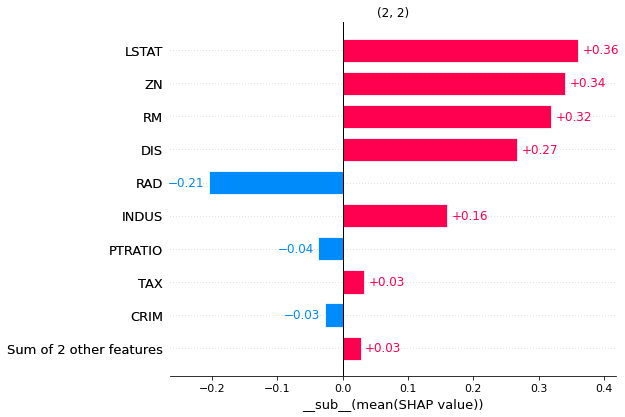

In [165]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [166]:
top_features = ['ZN', 'INDUS', 'LSTAT', 'RAD']

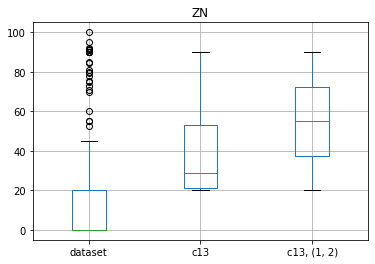

dataset        12.841063
c13            39.687500
c13, (1, 2)    55.000000
dtype: float64


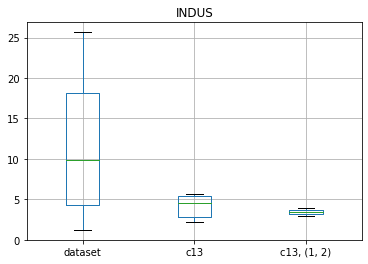

dataset        11.718208
c13             4.137500
c13, (1, 2)     3.470000
dtype: float64


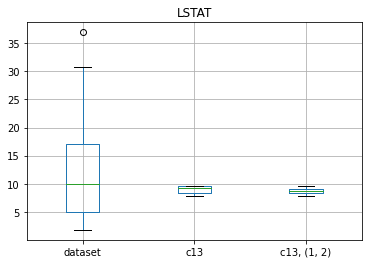

dataset        11.736981
c13             8.925280
c13, (1, 2)     8.686121
dtype: float64


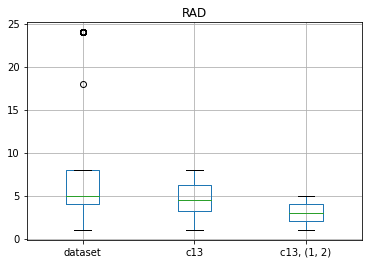

dataset        9.346908
c13            4.500000
c13, (1, 2)    3.000000
dtype: float64


In [167]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()
    print(df.mean())

### Feature effects

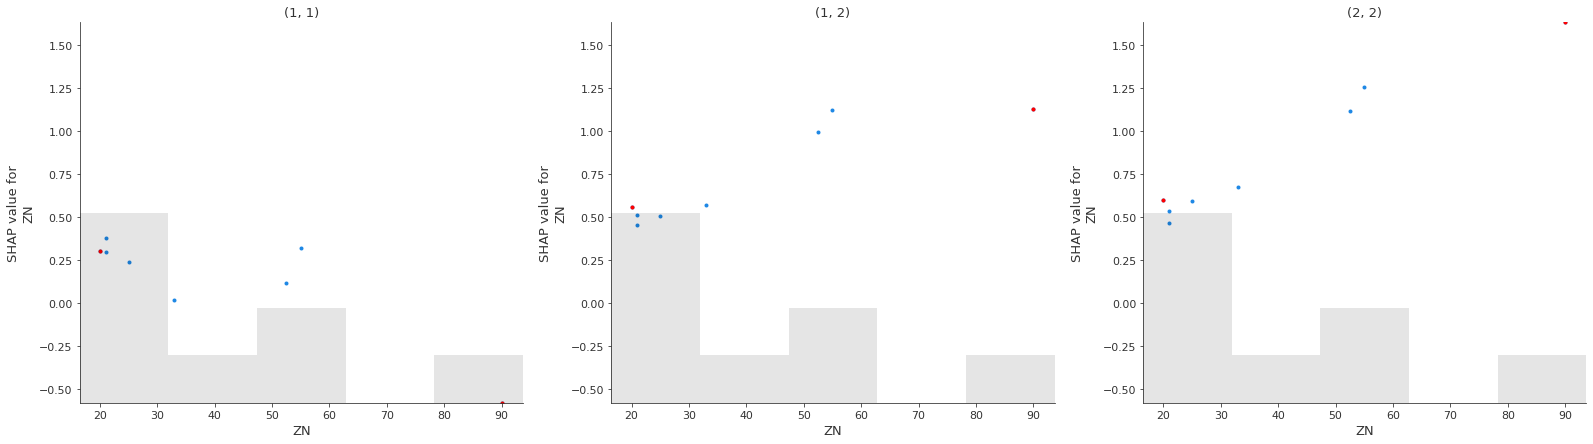

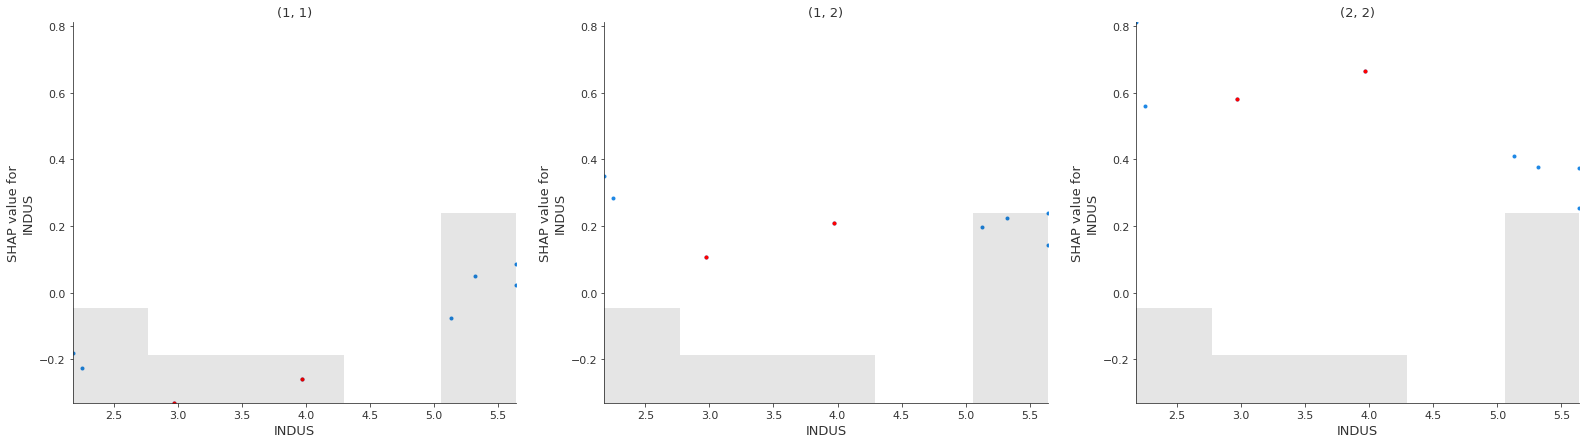

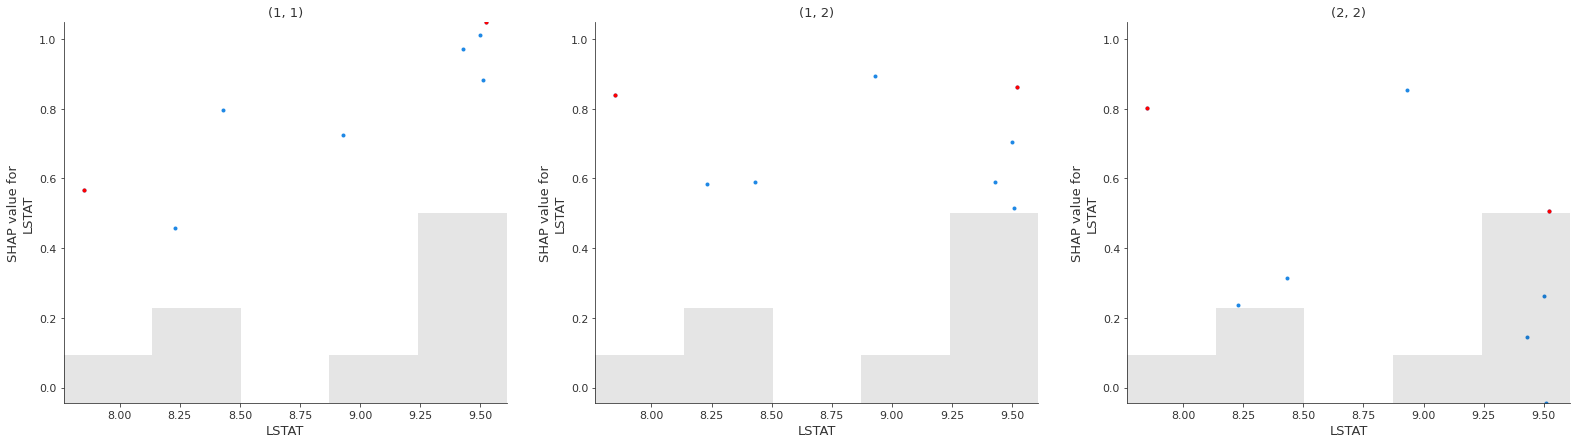

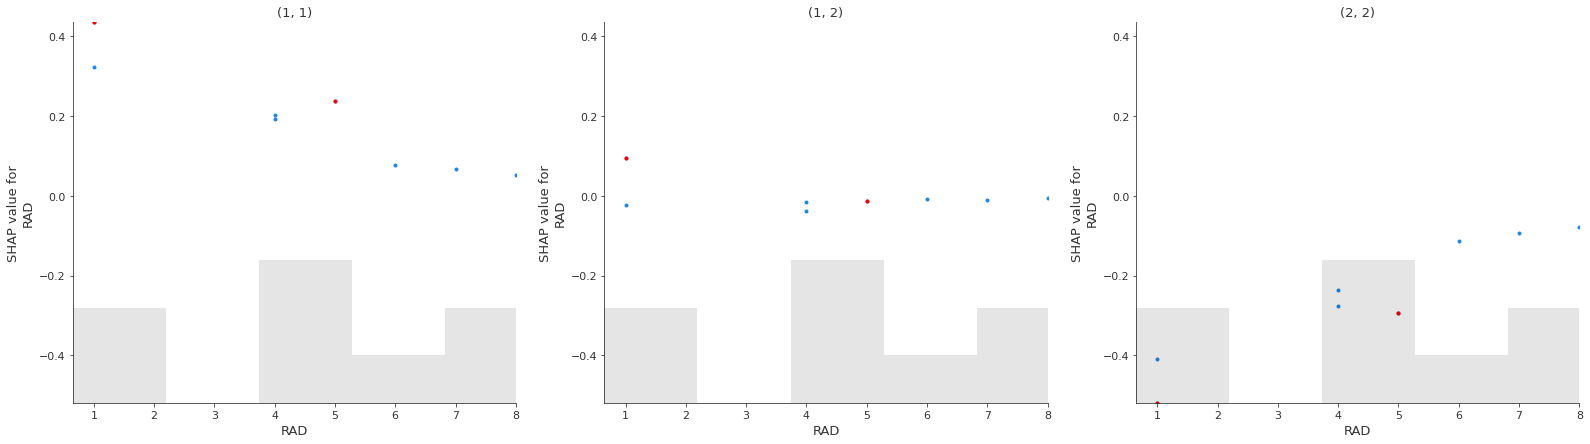

In [168]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the feature's value, I found out that the classifiers don't agree always for these instances:
- ZN: 16-34 and 86-104
- INDUS: <17
- RAD: <12

In [174]:
idx_feature = feature_idx_of('ZN')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] -= 4
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [20. 90.]
['(1, 1)' '(1, 2)']
stop:  [16. 86.]


In [184]:
idx_feature = feature_idx_of('ZN')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] += 14
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [20. 90.]
['(2, 2)' '(2, 2)']
stop:  [ 34. 104.]


In [219]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] += 14
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [3.97 2.97]
['(1, 1)' '(1, 1)']
stop:  [17.97 16.97]


In [193]:
idx_feature = feature_idx_of('RAD')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] += 7
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [5. 1.]
['(2, 2)' '(2, 2)']
stop:  [12.  8.]


### diro2c

In [204]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 40.6 s, sys: 204 ms, total: 40.8 s
Wall time: 41.1 s


diro2c suggests, that there are more differences possible for ZN and RAD over the entire value range. For INDUS, it confirms, that there are differences up to 17 but that there are less between 10 and 15.

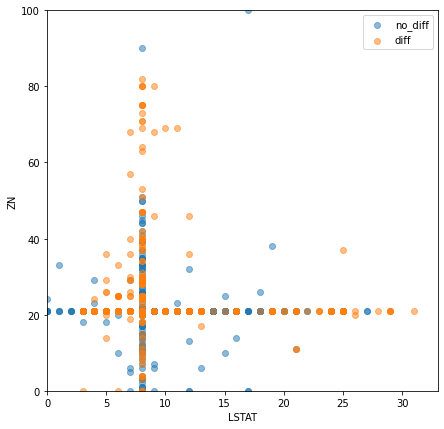

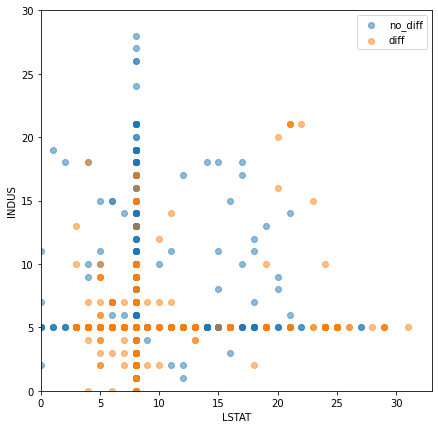

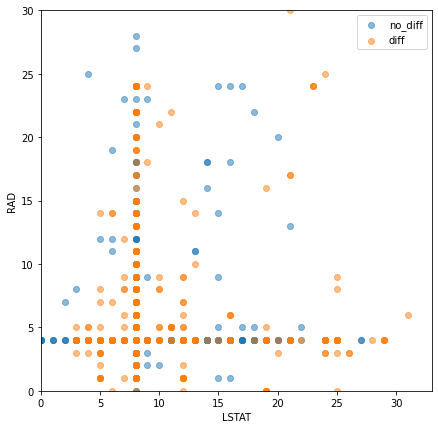

In [222]:
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'ZN', xlim=(0, 33), ylim=(0, 100))
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'INDUS', xlim=(0, 33), ylim=(0, 30))
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'RAD', xlim=(0, 33), ylim=(0, 30))

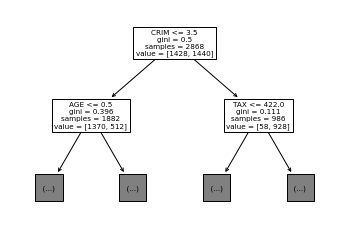

In [223]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 5th cluster (mean LSTAT = 12.2)

In [224]:
cluster = clusters_of_interest[4]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

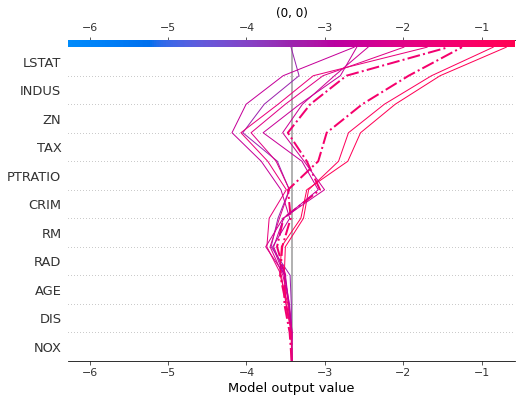

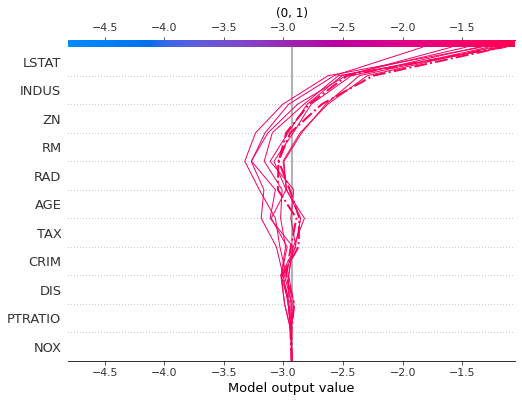

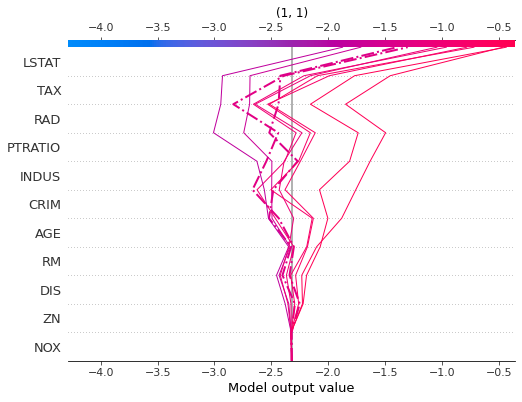

In [225]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

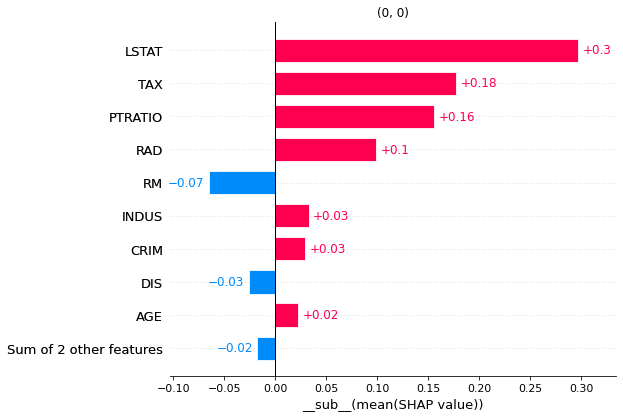

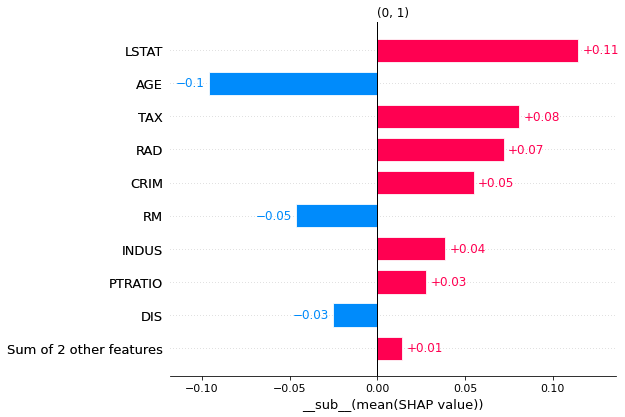

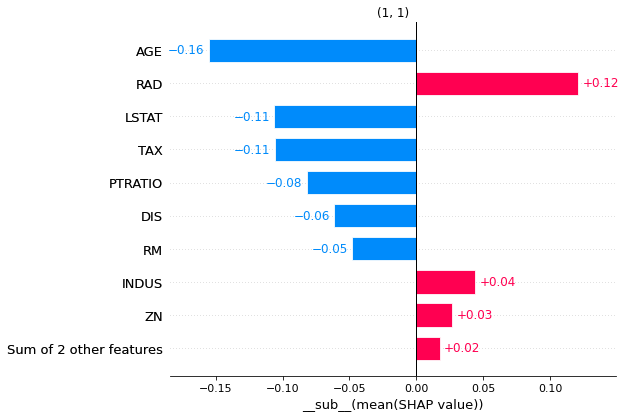

In [226]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [228]:
top_features = ['AGE', 'LSTAT', 'TAX', 'RM']

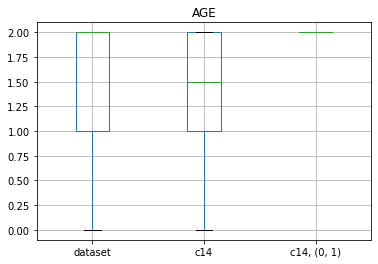

dataset        1.304878
c14            1.400000
c14, (0, 1)    2.000000
dtype: float64


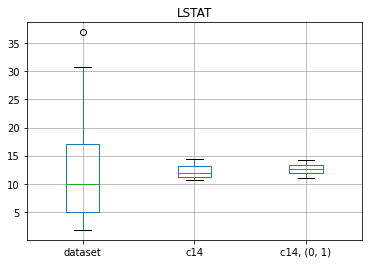

dataset        11.736981
c14            12.230000
c14, (0, 1)    12.645000
dtype: float64


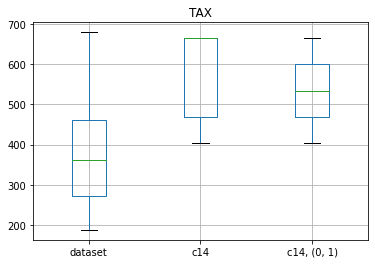

dataset        403.132604
c14            587.100000
c14, (0, 1)    534.500000
dtype: float64


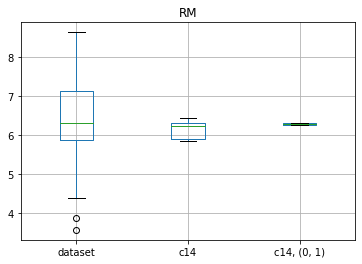

dataset        6.511388
c14            6.130000
c14, (0, 1)    6.285000
dtype: float64


In [229]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()
    print(df.mean())

### Feature effects

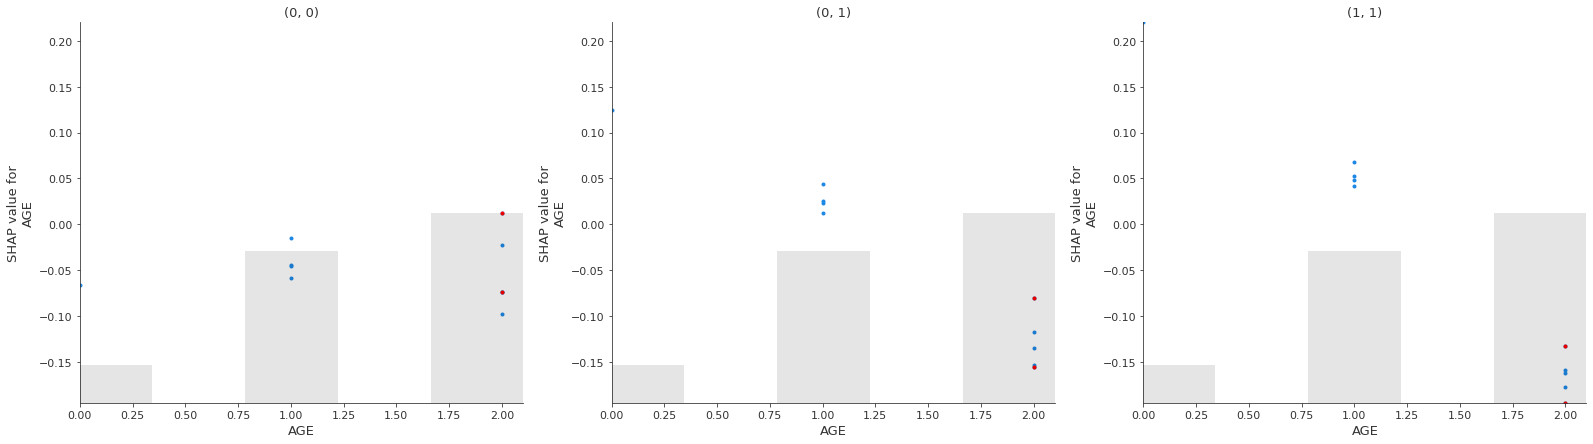

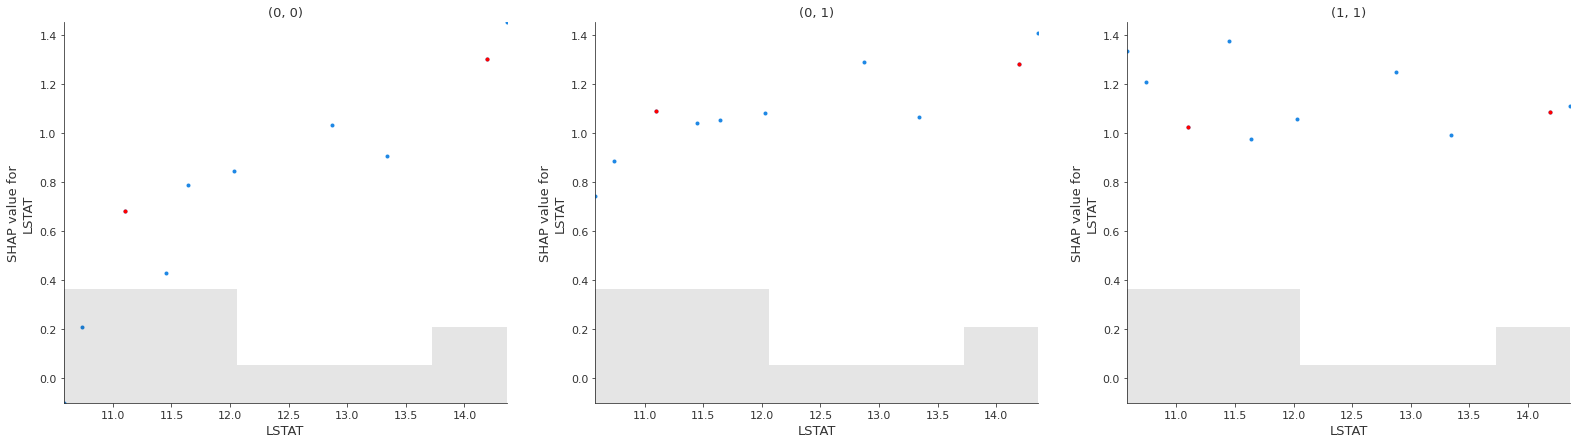

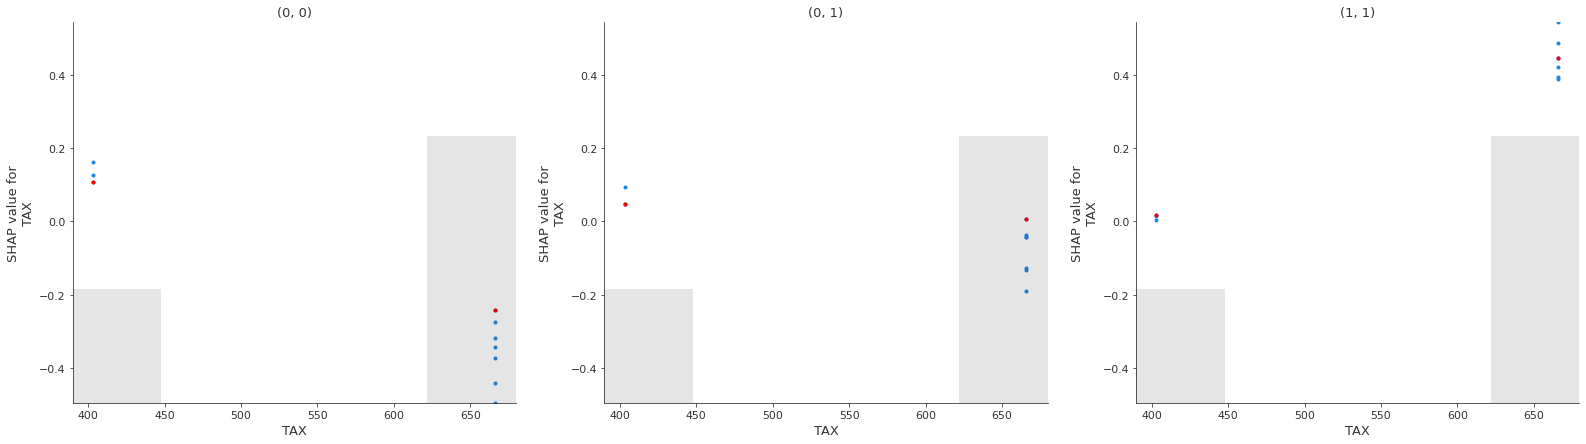

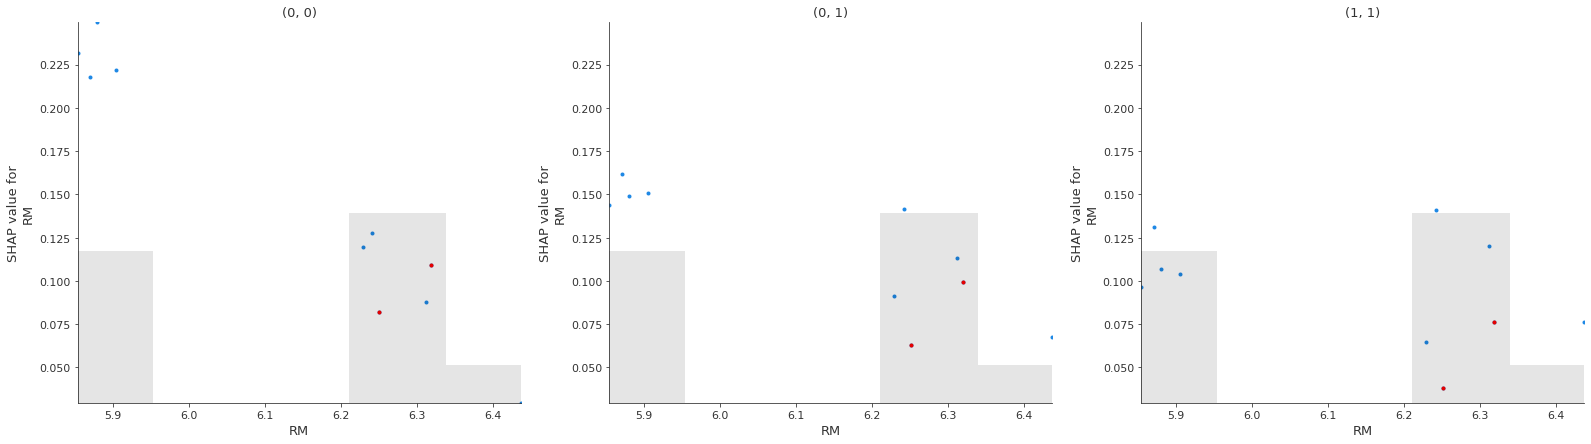

In [230]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the feature's value, I found out that the classifiers don't agree always for these instances:
- AGE: 1 and 2
- TAX: 403-452 and 666-689
- RM: 6.2-7.4

In [235]:
idx_feature = feature_idx_of('AGE')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] = 0
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [2. 2.]
['(1, 1)' '(1, 1)']
stop:  [0. 0.]


In [265]:
idx_feature = feature_idx_of('TAX')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[0, idx_feature] += 23
d[1, idx_feature] += 49
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [666. 403.]
['(1, 1)' '(1, 1)']
stop:  [689. 452.]


In [255]:
idx_feature = feature_idx_of('TAX')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] += 49
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [666. 403.]
['(1, 1)' '(1, 1)']
stop:  [715. 452.]


In [272]:
idx_feature = feature_idx_of('RM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] += 1.1
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [6.251 6.319]
['(1, 1)' '(1, 1)']
stop:  [7.351 7.419]


In [277]:
idx_feature = feature_idx_of('RM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] -= 0.5
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [6.251 6.319]
['(0, 0)' '(0, 0)']
stop:  [5.751 5.819]


In [193]:
idx_feature = feature_idx_of('RAD')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] += 7
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [5. 1.]
['(2, 2)' '(2, 2)']
stop:  [12.  8.]


### diro2c

In [278]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 46 s, sys: 531 ms, total: 46.5 s
Wall time: 50.3 s


We can see, that there might be also differences for AGE=0. TAX may have more differences from 300 upwards as well. For RM, there might only be more differences for down to 5.

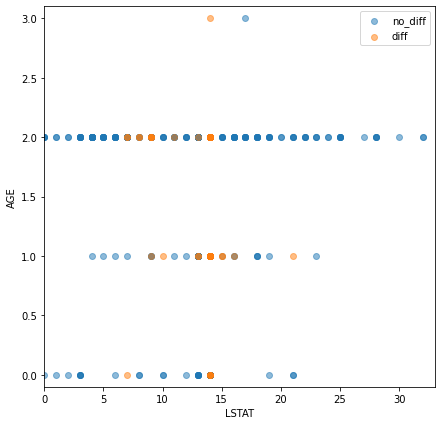

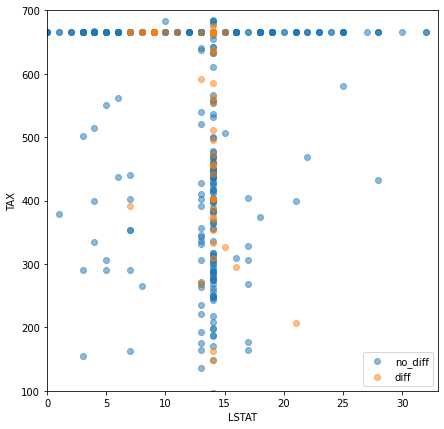

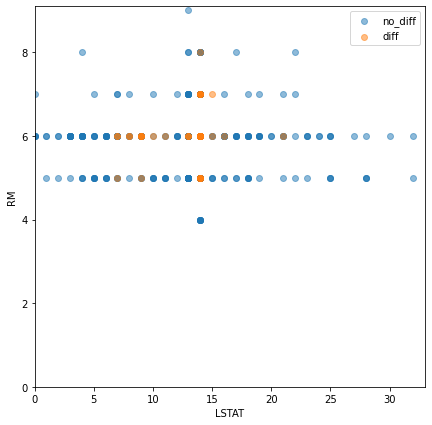

In [284]:
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'AGE', xlim=(0, 33), ylim=(-0.1, 3.1))
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'TAX', xlim=(0, 33), ylim=(100, 700))
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'RM', xlim=(0, 33), ylim=(0, 9.1))

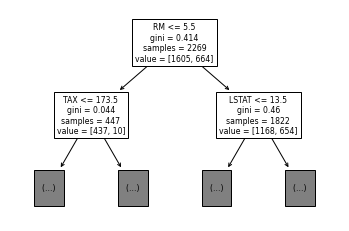

In [285]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

## 6th cluster (mean LSTAT = 15.5)

In [287]:
cluster = clusters_of_interest[5]
classes = occurences.columns[occurences.loc[cluster, :] > 0].to_numpy()
confusion_class = np.intersect1d(classes, comparer.difference_class_names)[0]
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster][:, :, classes]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

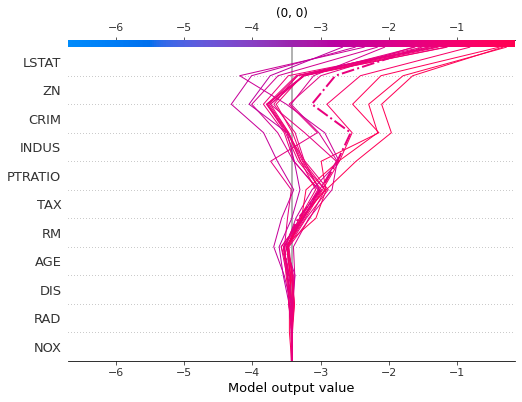

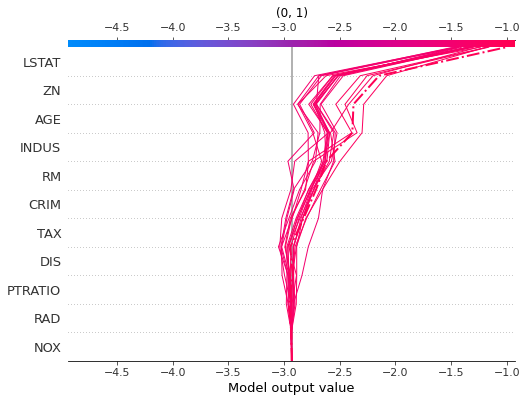

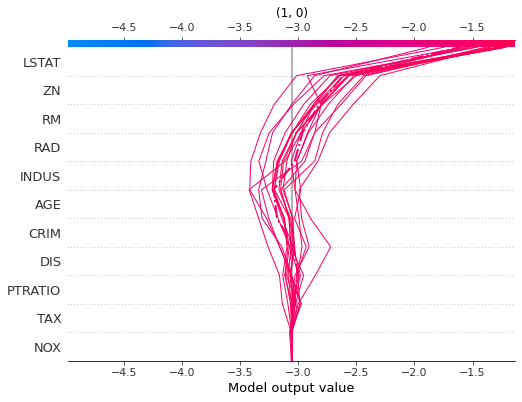

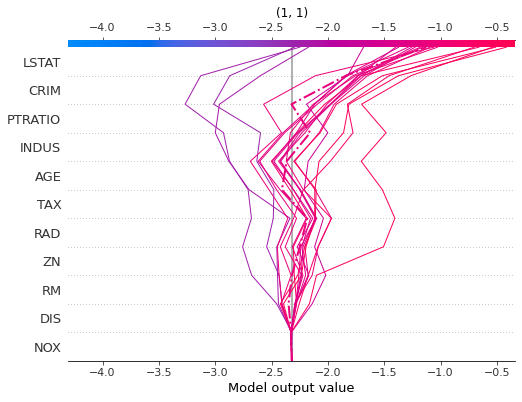

In [288]:
for class_ in classes:
    plot_decision(shap_values[:, :, class_], instances_confused)

### Bar plots

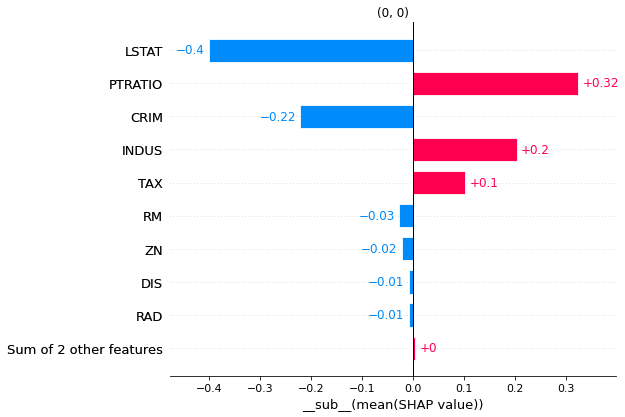

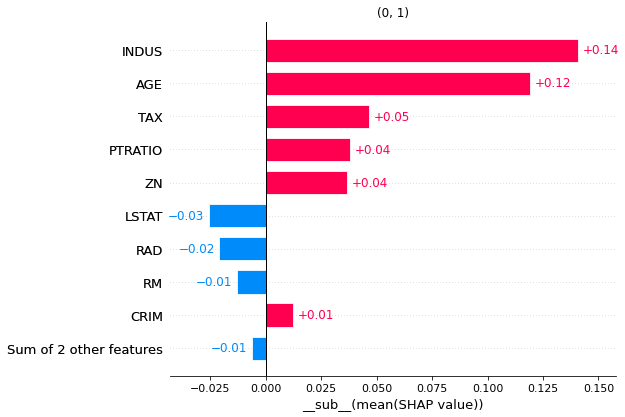

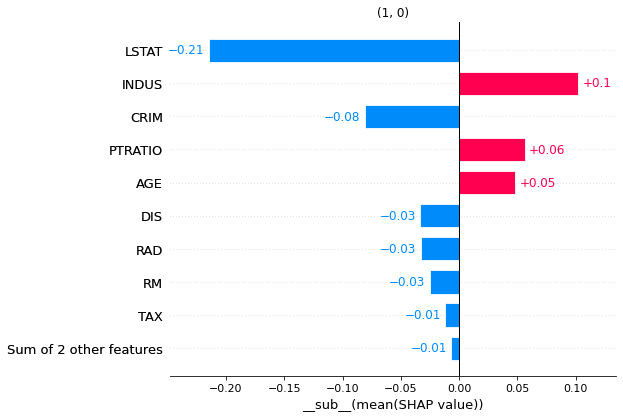

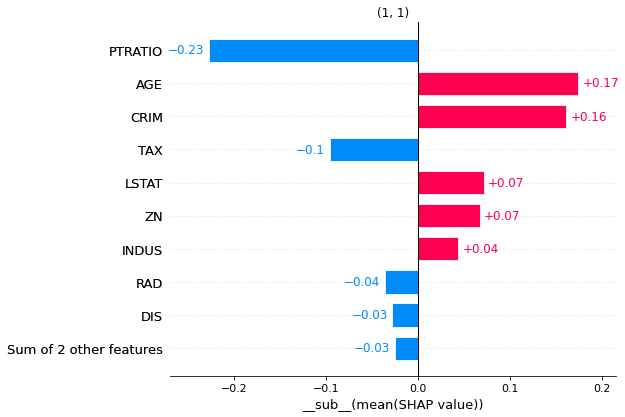

In [289]:
for class_ in classes:
    plt.title(class_)
    shap.plots.bar(shap_values[instances_confused, :, class_].mean(0) -
                   shap_values[~instances_confused, :, class_].mean(0))

In [290]:
top_features = ['LSTAT', 'CRIM', 'PTRATIO', 'INDUS']

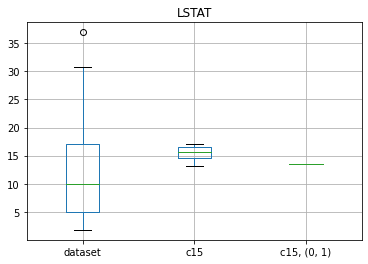

dataset        11.736981
c15            15.509689
c15, (0, 1)    13.510000
dtype: float64


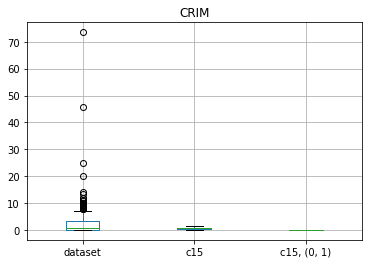

dataset        2.720010
c15            0.585764
c15, (0, 1)    0.045600
dtype: float64


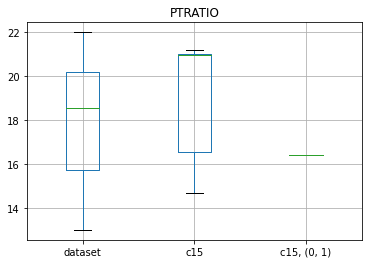

dataset        18.125578
c15            19.045000
c15, (0, 1)    16.400000
dtype: float64


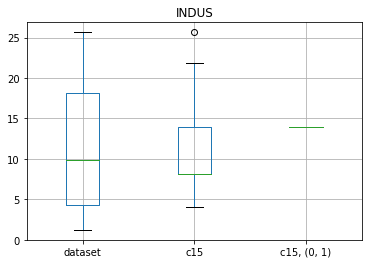

dataset        11.718208
c15            11.242500
c15, (0, 1)    13.890000
dtype: float64


In [291]:
for feature_name in top_features:
    df = pd.concat([pd.Series(explanations[:, feature_name].data),
                    pd.Series(shap_values[:, feature_name].data),
                    pd.Series(shap_values[instances_confused, feature_name].data)], axis=1)
    df.columns = ['dataset', cluster, f'{cluster}, {confusion_class}']
    df.boxplot()
    plt.title(feature_name)
    plt.show()
    print(df.mean())

### Feature effects

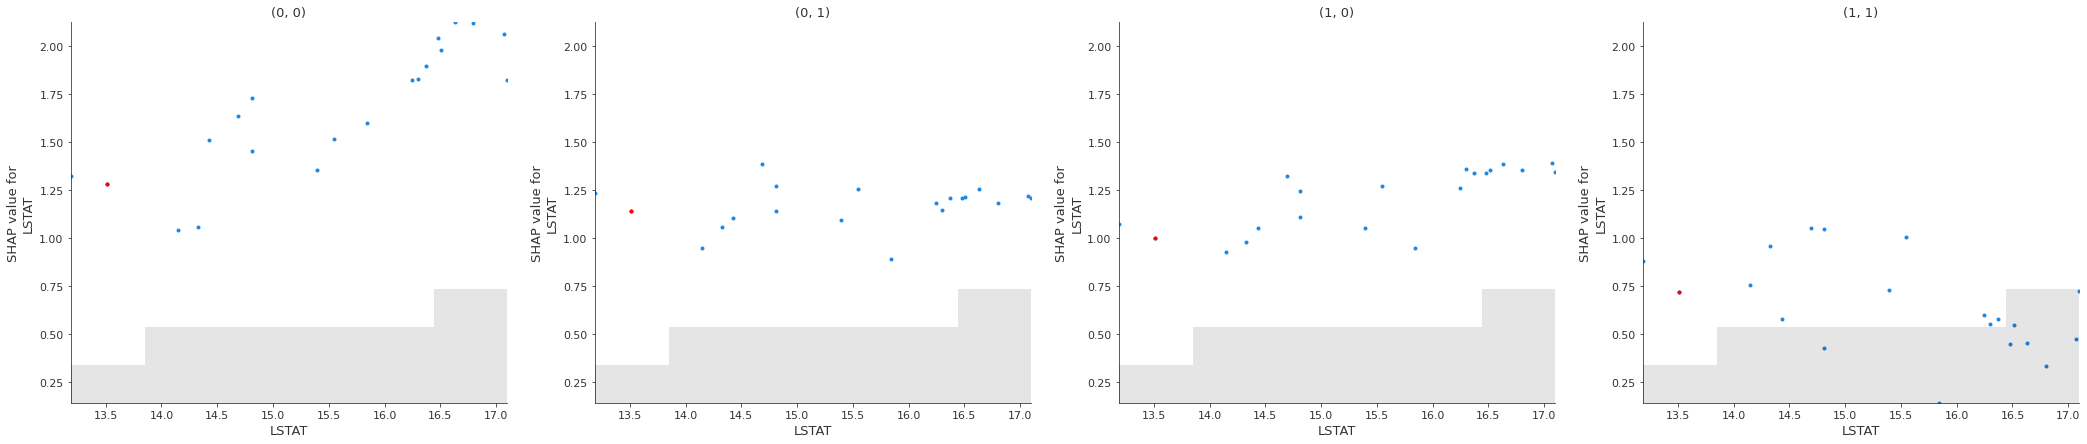

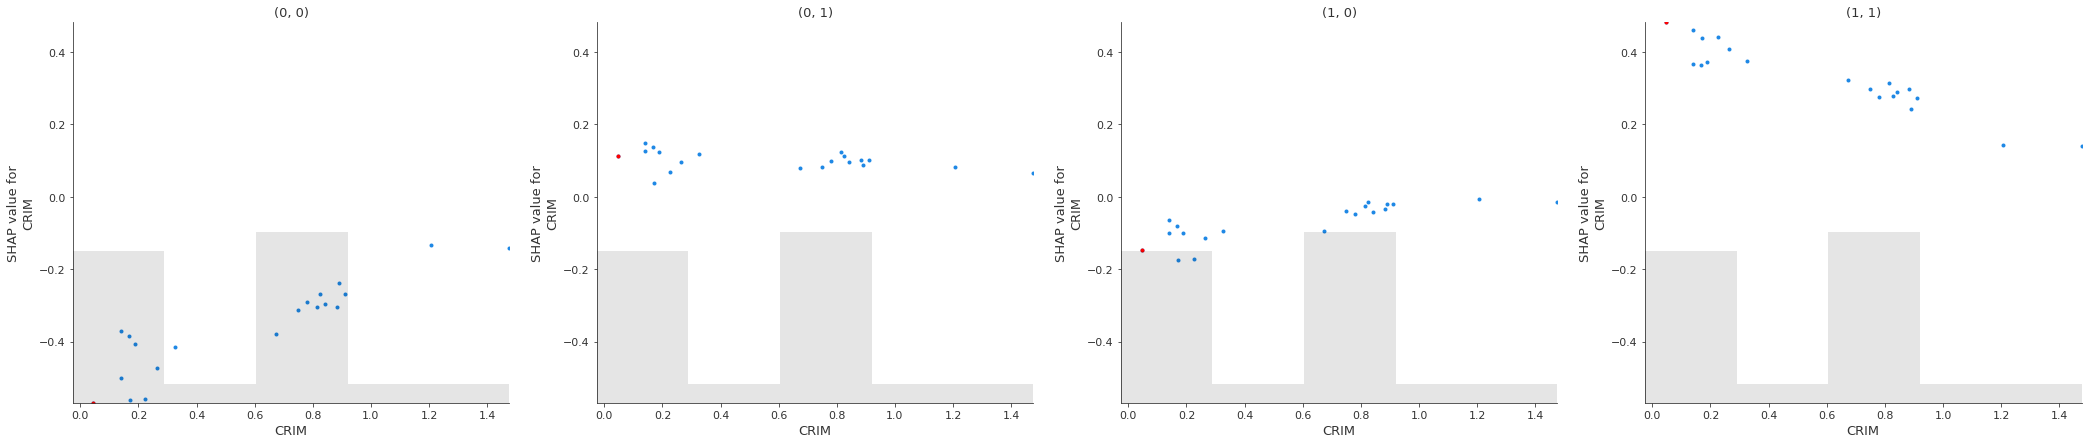

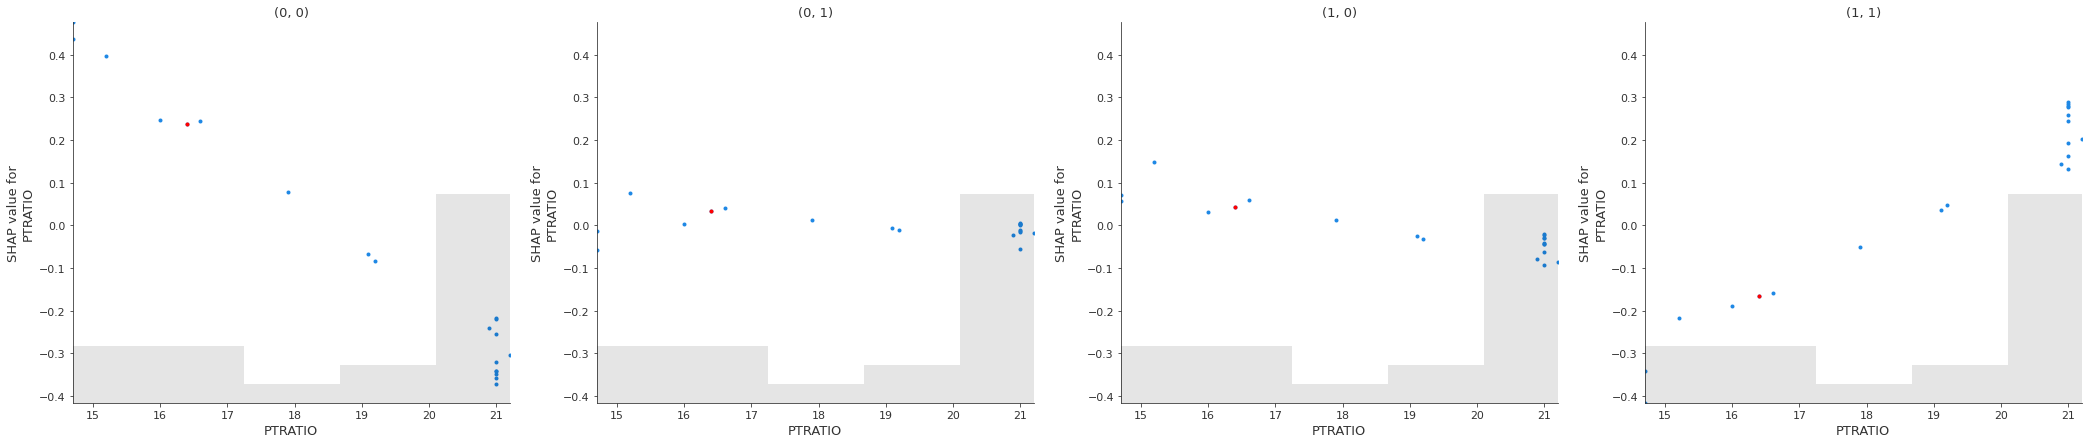

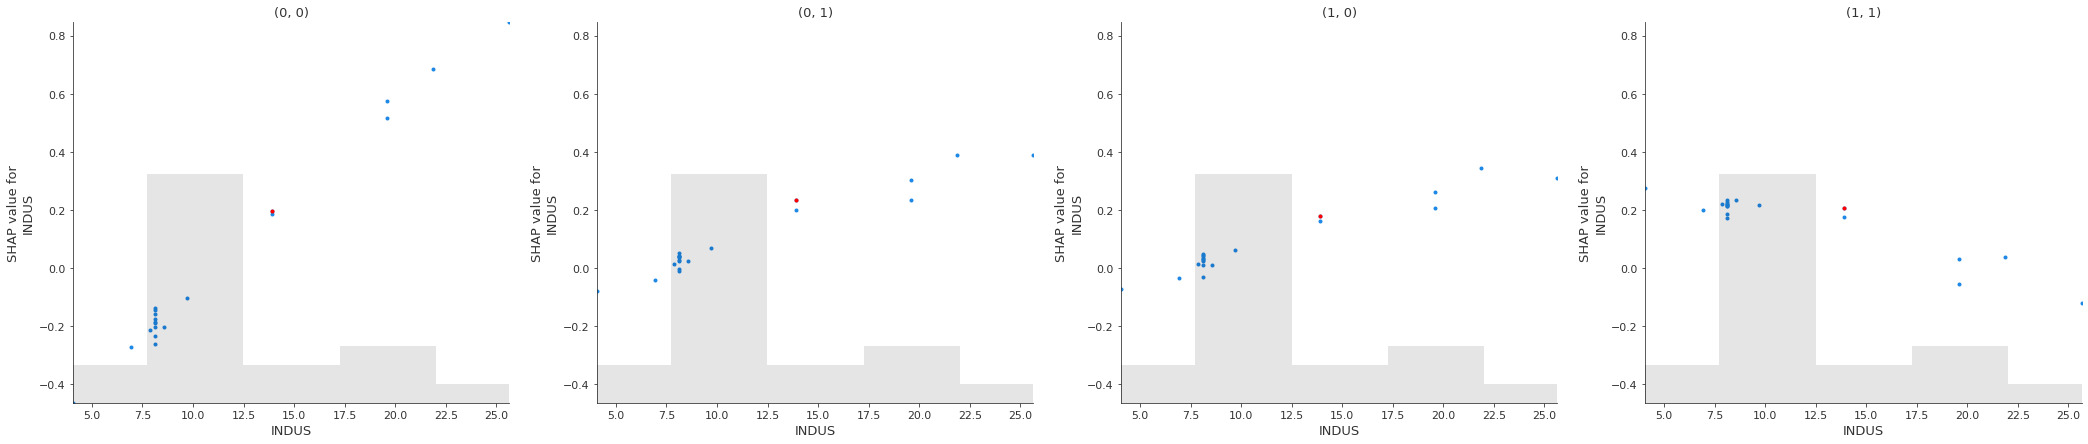

In [292]:
for feature in top_features:
    plot_feature_effects(shap_values[:, [feature]], highlight=instances_confused)

By gradually increasing or decreasing the feature's value, I found out that the classifiers don't agree always for these instances:
- CRIM: <1.3
- PTRATIO: 13.3-17.1
- INDUS: 12.3-22.2

In [304]:
idx_feature = feature_idx_of('CRIM')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] += 1.3
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [0.0456]
['(0, 0)']
stop:  [1.3456]


In [309]:
idx_feature = feature_idx_of('PTRATIO')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] += 0.7
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [16.4]
['(1, 1)']
stop:  [17.1]


In [319]:
idx_feature = feature_idx_of('PTRATIO')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] -= 3.1
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [16.4]
['(0, 0)']
stop:  [13.3]


In [332]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] += 8.3
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [13.89]
['(0, 0)']
stop:  [22.19]


In [341]:
idx_feature = feature_idx_of('INDUS')
mask = instances_confused
d = shap_values.data[mask].copy()
print(f'start: {d[:, idx_feature]}')
d[:, idx_feature] -= 1.6
pred_class_names = comparer.class_names[comparer.predict_mclass_diff(d)]
print(pred_class_names)
print(f'stop:  {d[:, idx_feature]}')

start: [13.89]
['(1, 1)']
stop:  [12.29]


### diro2c

In [342]:
%%time
idx_explain = np.where(cluster_names[clustering] == cluster)[0][0]
bin_diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                                  diff_classifier_method_type.binary_diff_classifier, gn_population_size=10000,
                                                  data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)
dc_info = bin_diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
evaluation_info = dc_info['evaluation_info']

CPU times: user 43.2 s, sys: 340 ms, total: 43.6 s
Wall time: 45.1 s


For CRIM, diro2c suggests that there are more differences up to 3, for PTRATIO it found more up to 21, but none at 13 and 14. For INDUS it suggests, there are more between 5 and 10.

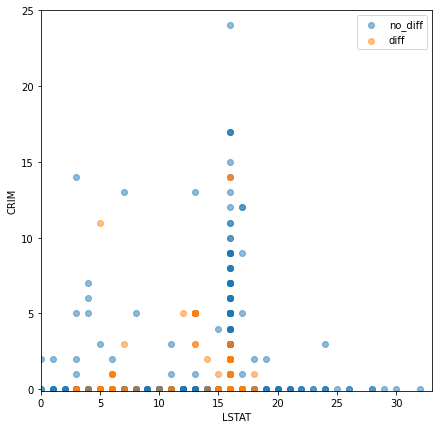

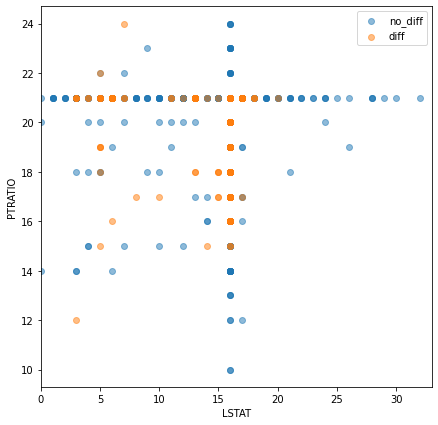

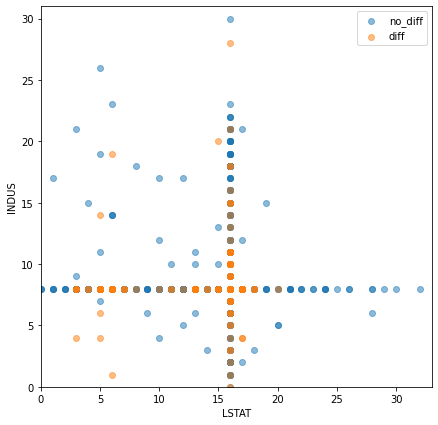

In [344]:
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'CRIM', xlim=(0, 33), ylim=(-0.1, 25))
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'PTRATIO', xlim=(0, 33))
plot_diro2c(evaluation_info['X'], evaluation_info['y'], 'LSTAT', 'INDUS', xlim=(0, 33), ylim=(0, 31))

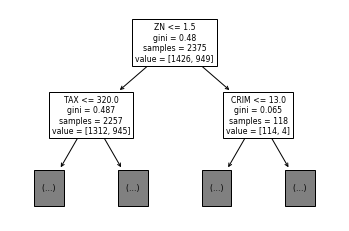

In [345]:
plot_tree(dc_full, max_depth=1, feature_names=comparer.feature_names);

# Conclusion

Applying this method a second time on a different task, I noticed the following:

Drawbacks of manually modifying feature values to find decision boundaries:
- Changing only one feature value at a time might lead to unrealistic feature value combinations
- By using only instances from the test set, other areas with possible differences might be missed

Drawbacks of diro2c:
- It does not yet distinguish between the individual confusion classes, and this let's the data scientist in doubt whether the shown differences are related to the current cluster or not
- The genetic neighborhood generation algorithm does not take the already available information into account: It would be ideal, to only modify the most relevant features, and it should take into account the minimum and maximum values in the dataset.

Extending diro2c would make it the perfect companion method for this approach, especially because it generates new instances, where there is a lack of in the SHAP-based approach. It could even be applied to other clusters, where there are no instances classified differently.

**Confidence:**

With the two tools agreeing on most of the differences, but diro2c suggesting many more differences, I'm not overly confident (2 of 4) that I found all relevant differences. With the above noted extension of diro2c, I think it's possible to gain good confidence (1 of 4) about the explanations, while not reducing their selectiveness.